# RNN with TensorFlow, Practice RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Rahman\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Create Class

In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [3]:
ts_data = TimeSeriesData(250,0,10)

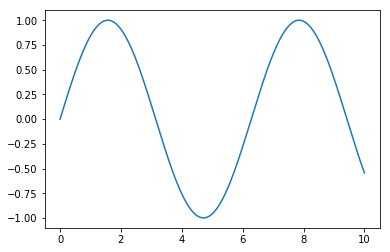

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

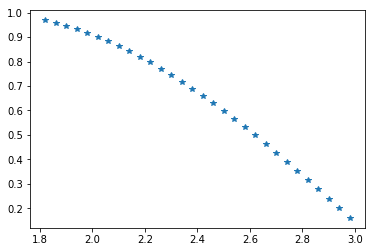

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

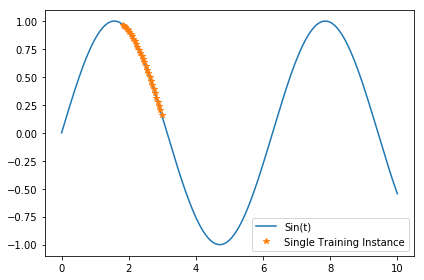

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

### A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [9]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

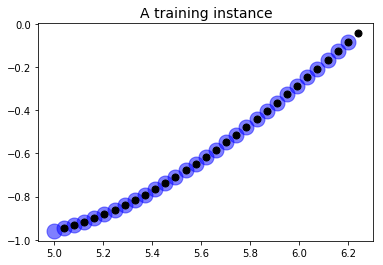

In [10]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

___________

# Creating the Model

In [11]:
tf.reset_default_graph()

### Constants

In [12]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate
learning_rate = 0.001
# 6000 iterations to go through (training steps)
num_train_iterations = 6000
# Size of the batch of data
batch_size = 1

### Placeholders

In [13]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

### RNN Cell Layer

Let's check different RNN model and compare how they perform against each other.

In [14]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [15]:
#cell = tf.contrib.rnn.OutputProjectionWrapper(
 #    tf.nn.rnn_cell.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu, reuse=tf.AUTO_REUSE),
  #      output_size=num_outputs)

In [16]:
#n_neurons = 100
#n_layers = 3

#cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
 #             for layer in range(n_layers)])

In [17]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

In [18]:
#n_neurons = 100
#n_layers = 3

#cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(num_units=n_neurons)
             # for layer in range(n_layers)])

### Dynamic RNN Cell

In [19]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [20]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Initialize Variables

In [21]:
init = tf.global_variables_initializer()

## Session

In [22]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [23]:
saver = tf.train.Saver()

In [24]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.3228374
100 	MSE: 0.03250297
200 	MSE: 0.015860777
300 	MSE: 0.009971309
400 	MSE: 0.0030320638
500 	MSE: 0.009768297
600 	MSE: 0.0065272613
700 	MSE: 0.00193996
800 	MSE: 0.008440605
900 	MSE: 0.0038343715
1000 	MSE: 0.0009007418
1100 	MSE: 0.002405488
1200 	MSE: 0.0003981636
1300 	MSE: 0.004556142
1400 	MSE: 5.061123e-05
1500 	MSE: 0.00011615058
1600 	MSE: 0.000646254
1700 	MSE: 0.0001921747
1800 	MSE: 8.448751e-05
1900 	MSE: 8.249483e-05
2000 	MSE: 5.3909665e-05
2100 	MSE: 4.727021e-05
2200 	MSE: 0.00010692671
2300 	MSE: 0.00044968745
2400 	MSE: 0.0001022164
2500 	MSE: 7.632201e-05
2600 	MSE: 5.919567e-05
2700 	MSE: 2.8061188e-05
2800 	MSE: 0.00020074753
2900 	MSE: 0.0002811663
3000 	MSE: 0.0016963306
3100 	MSE: 0.00046904702
3200 	MSE: 0.00010094799
3300 	MSE: 1.2917833e-05
3400 	MSE: 6.6796136e-05
3500 	MSE: 0.00017766227
3600 	MSE: 6.194985e-05
3700 	MSE: 8.649616e-05
3800 	MSE: 7.040811e-06
3900 	MSE: 6.9040984e-06
4000 	MSE: 5.437162e-05
4100 	MSE: 5.873972e-05
4200 	

### Predicting time series t+1

In [25]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


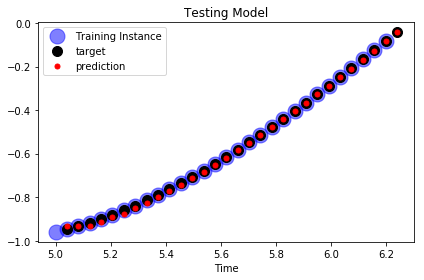

In [26]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequences

In [27]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0,0.5,'Value')

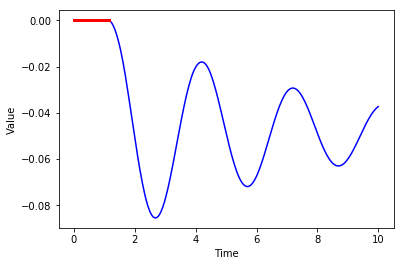

In [28]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [29]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0.5,0,'Time')

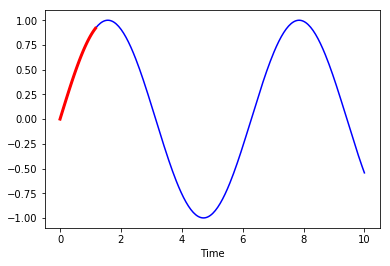

In [30]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")